In [1]:
'''
45325919, Anthony Cerqui
https://github.com/littletuna4/bism3206-assign
'''

'\n45325919, Anthony Cerqui\nhttps://github.com/littletuna4/bism3206-assign\n'

In [2]:
#Use this cell to import all the required libraries.
# %pip install gensim colorama nltk scikit-learn matplotlib seaborn pandas numpy scipy<1.13 ipykernel openpyxl vadersentiment


# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neural_network import MLPClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Flavour
from colorama import Fore, Style

# nltk downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# #your work should only start with the following code
# df=pd.read_excel("Assignment_Data.xlsx")

# # Trim it up for dev purposes we only want say 1%
# df = df.sample(frac=0.01, random_state=1)
# # save to csv
# df.to_csv("Assignment_Data_1pc.csv", index=False)

df = pd.read_csv("Assignment_Data_1pc.csv")

#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

_In this cell, in no more than 200 words, you can elaborate on the major understanding of data based on your data exploration._

The dataset relates to social media data, containing information about news authors, headlines, tweets, and various metrics about user engagement and demographic details. It has a total of 134,198 entries across 16 features, without duplicate entries, indicating good data cleanliness in terms of redundancy. Several features have a significant amount of missing data, particularly user_following and user_country, which could impact analysis related to user demographics and behavior.

The descriptive statistics reveal a highly skewed distribution in engagement metrics (post_replies, post_retweets, post_favourites, post_quotes), with most posts receiving zero engagement but a few outliers receiving extremely high interaction, suggesting viral behavior for a minority of posts. User metrics like user_followers, user_favourites, and user_tweets_count also display wide variances, indicating a diverse user base from minimally active to influential users.

Misinformation flagged in roughly half of the entries (mean=0.514), highlighting the dataset's utility for studying the spread and impact of misinformation across social platforms. The data includes a variety of unique authors, headlines, and tweets, which can be useful for textual analysis and pattern recognition in social media discussions. The significant presence of missing values, especially in demographic-related columns, suggests a need for careful handling and possibly imputation techniques for more robust analyses.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   news_author             1342 non-null   object 
 1   news_headline           1341 non-null   object 
 2   related_tweet           1342 non-null   object 
 3   post_replies            1342 non-null   float64
 4   post_retweets           1342 non-null   int64  
 5   post_favourites         1342 non-null   int64  
 6   post_quotes             1342 non-null   int64  
 7   user_followers          1342 non-null   float64
 8   user_following          451 non-null    float64
 9   user_friends            1342 non-null   float64
 10  user_mentions           1341 non-null   float64
 11  user_favourites         1342 non-null   float64
 12  user_tweets_count       1342 non-null   float64
 13  user_tweet_count_lists  1342 non-null   float64
 14  user_country            665 non-null    

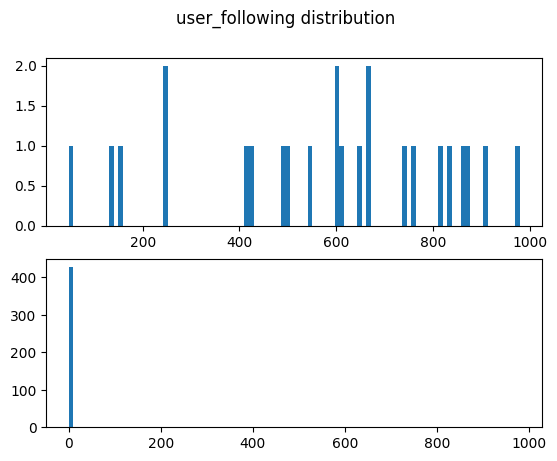

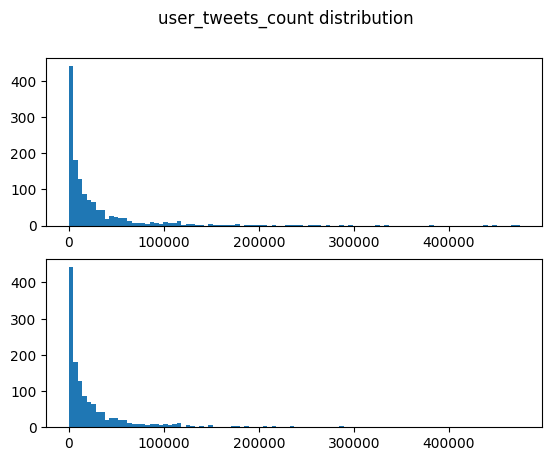

In [4]:
#Use this cell for data exploration.

def deco(a_string):
  return Style.BRIGHT+Fore.BLUE+a_string+Style.RESET_ALL


# here's some general first-pass stuff
print(
    deco("df.head()\n"),df.head(),
    deco("df.info()\n"),df.info(),
    deco("df.describe()\n"),df.describe(),
    deco("df.columns\n"),df.columns,
    deco("df.shape\n"),df.shape,
    deco("df.isnull().sum()\n"),df.isnull().sum(),
    deco("df.duplicated().sum()\n"),df.duplicated().sum(),
    deco("df.nunique()\n"),df.nunique(),
    sep="\n"
)
# what are the unique types of each object column?   
print(
    deco("df.apply(lambda x: x.apply(lambda y: type(y)).value_counts(dropna=False))\n"),df.apply(lambda x: x.apply(lambda y: 'nan' if pd.isnull(y) else str(type(y))).value_counts()),
    sep="\n"
)

# Here's some more specific details after asking myself some questions
# What are the 161 unique news_authors? 
print(
    deco("df['news_author'].unique()\n"),df['news_author'].unique(),
    sep="\n"
)
# only 161 unique authors, that's not too bad and they're all well formatted. also, no doubt, these will be a good indicator; some will be more prone to missinformation. I probably won't process them much if at all - I'll just use them as a feature.



# the countries about an even split of string and nans - lets see how the text ones are distributed (also, lets check the form of the misinformation column)
print(
    deco("df['user_country'].value_counts()\n"),df['user_country'].value_counts(),
    deco("df['misinformation'].value_counts()\n"),df['misinformation'].value_counts(), # roughly even split 1.0, and 0.0
    sep="\n"
)
# mostly "US", and some "AU" - not many au though - I'll probably just drop this column
# lets compare the ratio of ratio of misinformation to not misinformation in the US and AU and other
print(
    deco("df[df['user_country']=='US']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='US']['misinformation'].value_counts(normalize=True), 
    deco("df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True),
    deco("df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True),
    sep="\n"
)
# Straight up, this column is not looking useful by itself - it'll only be considered for Simpon's paradox purposes - but that seems a hell of a stretch

# let's compare the ratio of misinformation to not misinformation for the user_following column - if the nan's have a different ratio to the 0's then, we should definetely use something better than just replacing them with 0
print(
    Fore.GREEN+Style.BRIGHT+"userFollowing\n"+Style.RESET_ALL,
    deco("df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True),
    deco("df[df['user_following']==0]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following']==0]['misinformation'].value_counts(normalize=True),
    # then for neither
    deco("df[(df['user_following'].isnull())or(df['user_following']==0)]['misinformation'].value_counts(normalize=True)\n"),df[(df['user_following'].isnull())|(df['user_following']==0)]['misinformation'].value_counts(normalize=True),
    sep="\n"  
)

# lets check the "user_following" col for distribution - lots of nans - lets see how the floats are distributed using a histogram of the frequency distribution of the non-nans and non-zeros
# fig, ax = plt.subplots() 
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_following distribution')
axs[1].hist(df['user_following'].dropna(), bins=100)
axs[0].hist(df['user_following'].replace(0,np.nan).dropna(), bins=100)

# do the samefor the user_tweets_count column
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_tweets_count distribution')
axs[1].hist(df['user_tweets_count'].dropna(), bins=100)
axs[0].hist(df['user_tweets_count'].replace(0,np.nan).dropna(), bins=100)


'''
these are the cols with relatively few nulls - let's see how many rows we'd lose if we dropped them (as a fraction of the whole data set)
news_headline -> drop
    related_tweet -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
'''
print(
    deco("df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0]\n"),df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0],
    sep="\n"
)
# .996 remains - thats fine to drop 'em


# Text preparation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

In [5]:
#Use this cell for text preparation.

# So it's easy to follow lets build the model df from scratch instead of ontop of the original df
mdf = pd.DataFrame()




'''
Null handling:
We don't really want to drop rows if it can be avoided, so we'll fill the null values with a placeholder where we can.
    Headlines -> drop
    Tweets -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
    User_following -> 0 (assuming they're not following anyone, far too many to drop)
    User_country -> "Other" (assuming they're not from the US or AU, far too many to drop)
'''
df_nulls_handled = df.copy()
# get a mask of the rows with nulls in the columns we want to drop
rows_to_drop = df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].isnull().any(axis=1)
df_nulls_handled = df_nulls_handled[~rows_to_drop] # drop them
# fill the user following and user_country columns
df_nulls_handled['user_following'] = df_nulls_handled['user_following'].fillna(0)
df_nulls_handled['user_country'] = df_nulls_handled['user_country'].fillna("Other")


'''
Lowercasing:
We can remove the case sensitivity of the text by converting all the words to lowercase.
'''
# I will apply this to the "news_headline" and "related_tweet" columns and add the lowercase versions to the new dataframe
mdf['headline_lower'] = df_nulls_handled['news_headline'].apply(lambda x: x.lower())
mdf['tweet_lower'] = df_nulls_handled['related_tweet'].apply(lambda x: x.lower())

'''
Stopword removal
We can remove unimportant words to reduce the computation load and improve the potency of the training data
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
'''
Punctuation and special character removal
Much like stopword removal, this technique is good for omitting unimportant data.
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))
mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))

'''
Tag Extraction
In twitter posts, we can extract tagged users by looking for words that start with a @ symbol, and tagged concepts by looking for words that start with a # symbol.
It's not as simple as just splitting the text by spaces, as the tags can be attached to words. so we'll split the text by spaces, filter for those with "@" or "#" in them at all, then split them by those symbols and remove the first element

'''
# Regex to find mentions and hashtags respectively
extract_mentions = lambda text : re.findall(r'(?:(?<=\s)|(?<=^))@\w[\w.]*', text)
extract_hashtags = lambda text: re.findall(r'#\w+', text)
mdf['mentions'] = df_nulls_handled['related_tweet'].apply(extract_mentions)
mdf['hashtags'] = df_nulls_handled['related_tweet'].apply(extract_hashtags)
# then lets get counts
mdf['mentions_count'] = mdf['mentions'].apply(len)
mdf['hashtags_count'] = mdf['hashtags'].apply(len)


'''
stemming
Stemming is a technique used to reduce words to their root form.
we can use the nltk library to stem words in the text.
'''
stemmer = nltk.stem.PorterStemmer()
mdf['headline_stemmed'] = mdf['headline_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
mdf['tweet_stemmed'] = mdf['tweet_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

'''
Tokenise the words using punkt

'''



'''
lemmatization
lemmatization is another technique used to reduce words to their root form.
'''
lemmatizer = nltk.stem.WordNetLemmatizer()
mdf['headline_lemmatized'] = mdf['headline_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
mdf['tweet_lemmatized'] = mdf['tweet_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


'''
Bag Of words
The bag of words model is a simple model that represents text data as a bag of words.
It ignores order and grammar, and only considers the frequency of words in the text - it also serves as
the input to TLF-IDF and Word2Vec models.
'''

# then we'll tokenize the text with punkt
mdf['tokens'] = ( mdf['headline_lower'] + " " + mdf['tweet_lower']).apply(word_tokenize)

'''
TFIDF -
TFIDF is a measure of how important a word is in a document.
It is calculated by multiplying the term frequency of a word in a document by the
inverse document frequency of the word across all documents.
'''
# we'll use the tokens to create a dictionary and a corpus
dictionary = corpora.Dictionary(mdf['tokens'])
corpus = [dictionary.doc2bow(text) for text in mdf['tokens']]
# then we'll create the tfidf model
tfidf = gensim.models.TfidfModel(corpus)
# and apply it to the corpus
mdf['tfidf'] = tfidf[corpus]






# finally lets take a look at the input dataframe
print(
    deco("mdf.head()\n"),mdf.head(),
    deco("mdf.info()\n"),mdf.info(),
    deco("mdf.describe()\n"),mdf.describe(),
    deco("mdf.columns\n"),mdf.columns,
    deco("mdf.shape\n"),mdf.shape,
    deco("mdf.isnull().sum()\n"),mdf.isnull().sum(),
    # deco("mdf.duplicated().sum()\n"),mdf.duplicated().sum(),
    # deco("mdf.nunique()\n"),mdf.nunique(),
    sep="\n"
)

<class 'pandas.core.frame.DataFrame'>
Index: 1339 entries, 0 to 1341
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   headline_lower       1339 non-null   object
 1   tweet_lower          1339 non-null   object
 2   mentions             1339 non-null   object
 3   hashtags             1339 non-null   object
 4   mentions_count       1339 non-null   int64 
 5   hashtags_count       1339 non-null   int64 
 6   headline_stemmed     1339 non-null   object
 7   tweet_stemmed        1339 non-null   object
 8   headline_lemmatized  1339 non-null   object
 9   tweet_lemmatized     1339 non-null   object
 10  tokens               1339 non-null   object
 11  tfidf                1339 non-null   object
dtypes: int64(2), object(10)
memory usage: 136.0+ KB
mdf.head()

                                      headline_lower  \
0                    says joe biden said racial slur   
1  early morning election results m

# Feature engineering

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

##### Feature 1 generation

In [10]:
#Use this cell for text feature_1 generation.

'''
Vadar sentiment
Vadar sentiment is a technique used to determine the sentiment of a text.
It understands the punctuation and capitalisation of the text, so we will use it the raw text.
'''
mdf['sentiment'] = df['related_tweet'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])


'''
LDA (Latent Dirichlet Allocation)
LDA is a technique used to extract topics from a text.
It is useful for understanding the underlying themes of a text.
The output is a list of topics, each with a list of words that represent the topic.
It can be applied to the bag of words model
In comparison to tfidf, LDA is a more advanced technique that can extract topics from a text.
'''
# ldaModel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, passes=10)
# topics = ldaModel.print_topics(num_words=4)
# for topic in topics:
#     print(topic)


'''
Word2Vec
Word2Vec is a technique used to represent words as vectors.
Suitable for preparing the data for neural networks models.
'''
word2vec = gensim.models.Word2Vec(mdf['tokens'], vector_size=100, window=5, min_count=1, workers=4)
# then we'll append the vectors to the dataframe
mdf['word2vec'] = mdf['tokens'].apply(lambda x: np.mean([word2vec.wv[word] for word in x], axis=0))
print(mdf['word2vec'])

'''
Dimensionality Reduction
Dimensionality reduction is a technique used to reduce the number of features in a dataset.
This reduces the computational load at the expense of some information loss.
'''



(0, '0.011*"vaccine" + 0.007*"says" + 0.006*"trump" + 0.006*"covid"')
(1, '0.012*"biden" + 0.009*"says" + 0.007*"joe" + 0.006*"americans"')
(2, '0.007*"states" + 0.006*"trump" + 0.006*"people" + 0.006*"tax"')
(3, '0.007*"says" + 0.007*"minimum" + 0.006*"wage" + 0.006*"people"')
0       [-0.017249588, 0.0410992, 0.01775405, -0.00183...
1       [-0.015644083, 0.029864728, 0.011707263, 0.002...
2       [-0.017337045, 0.034577608, 0.014588651, 0.000...
3       [-0.018128108, 0.046987094, 0.020246705, 0.002...
4       [-0.012722908, 0.022139866, 0.0081723435, 0.00...
                              ...                        
1337    [-0.016635882, 0.030097306, 0.010918916, 0.000...
1338    [-0.0079507595, 0.019449478, 0.008999776, 0.00...
1339    [-0.009364487, 0.020415945, 0.011605077, 0.000...
1340    [-0.009452703, 0.01996372, 0.0062093255, 0.002...
1341    [-0.021956913, 0.046820555, 0.021621125, 0.004...
Name: word2vec, Length: 1339, dtype: object


'\nDimensionality Reduction\nDimensionality reduction is a technique used to reduce the number of features in a dataset.\nThis reduces the computational load at the expense of some information loss.\n'

.
.
.

##### Feature N generation

In [ ]:
#Use this cell for text feature_N generation.

# Model Development
#### <font color="red">You must remove this section from your notebook before submission
<font color="black">This section is for you to work and develop any models you choose. <br>When you have found the best performing model, you should move it to the **Model building & evaluation** section below.

In [ ]:
#Use this cell for developing or evaluating model_1.

'''
Descision Tree/Random forest

'''

'''
POS Tagging
Considers Grammatical features of words
'''

'''
NNs
'''

.
.
.

In [ ]:
#Use this cell for developing or evaluating model_N.

# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

In this cell, in no more than 300 words, you can elaborate on development and performance of your best model.

In [ ]:
#Use this cell for the best models building & evaluation.